<a href="https://colab.research.google.com/github/enerhy/Portfolio/blob/master/Recognizing_Blood_Cells_disorders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# INTRO
[Kaggle Competition Blood Cells Classification](https://www.kaggle.com/paultimothymooney/blood-cells)

**Context:** The diagnosis of blood-based diseases often involves identifying and characterizing patient blood samples. Automated methods to detect and classify blood cell subtypes have important medical applications.

In this notebook:

* First, I build my custom CNN implementing Inception and ResNet Blocks. 
* Second, I use ResNet50 with partially pretrained weights for final prediction and comparisson with my model.

Additionally, I use Data Augumentation, different callbacks and TensorBoard as well.

# Set Up

In [3]:
# %tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

2.4.1


In [ ]:
!curl -s https://course.fast.ai/setup/colab | bash

Updating fastai...
Done.


In [4]:
# Basic Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import keras

# Imports for the Model
from tensorflow.keras.layers import Input, Add, Activation, Conv2D, ZeroPadding2D, Dense, Flatten, Dropout, GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, concatenate
from tensorflow.keras.applications.resnet50 import ResNet50 as ResNet50, preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam, RMSprop
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Preprocessing Images
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Saving and Loading
from tensorflow.keras.models import load_model

# Folder operations
from glob import glob
import sys, os

# Others
from sklearn.utils import shuffle

# Notebook Settings
pd.set_option('display.max_columns', None, 'display.max_rows', 100)

# Dataset Preperation

In [ ]:
# It is important to place the data into the system path since loading images
# from drive is very slow
from zipfile import ZipFile
file_name = '/content/drive/My Drive/Colab Notebooks/Blood_Cells/images.zip'

with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [ ]:
# This would be the same
# import os
# import zipfile

# local_zip = '/tmp/cats_and_dogs_filtered.zip'

# zip_ref = zipfile.ZipFile(local_zip, 'r')

# zip_ref.extractall('/tmp')
# zip_ref.close()

In [ ]:
# Getting to the folder we need
%cd /content/images
!ls

/content/images
TEST  TEST_SIMPLE  TRAIN


In [ ]:
print('TRAIN')
!ls TRAIN
print()
print('TEST')
!ls TEST
print()
print('TEST_SIMPLE')
!ls TEST_SIMPLE

TRAIN
EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL

TEST
EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL

TEST_SIMPLE
EOSINOPHIL  LYMPHOCYTE	MONOCYTE  NEUTROPHIL


In [ ]:
# Holding the paths:
train_path = 'TRAIN'
valid_path = 'TEST'
test_path = 'TEST_SIMPLE'

# useful for getting number of files
image_files = glob(train_path + '/*/*.jp*g')
valid_image_files = glob(valid_path + '/*/*.jp*g')
test_images = glob(test_path + '/*/*.jp*g')

Basic EDA

In [ ]:
# Number of classes
# useful for getting number of classes
folders = glob(train_path + '/*')
K = len(folders)
print('Number of classes: {}'.format(K))

Number of classes: 4


In [ ]:
# Number of images in the different datasets
print('# Training Images {}'.format(len(image_files)))
print('# Validation Images {}'.format(len(valid_image_files)))
print('# Testing Images {}'.format(len(test_images)))

# Training Images 9957
# Validation Images 2487
# Testing Images 71


Distribution of the train set classes


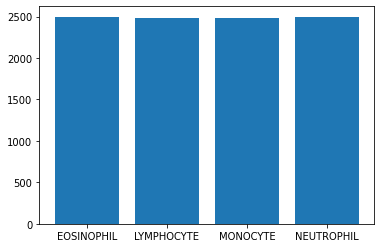

In [ ]:
# Checking the Distribution of the train classes
print('Distribution of the train set classes')
tm1 = glob(train_path + '/EOSINOPHIL' +  '/*.jp*g')
tm2 = glob(train_path + '/LYMPHOCYTE' +  '/*.jp*g')
tm3 = glob(train_path + '/MONOCYTE' +  '/*.jp*g')
tm4 = glob(train_path + '/NEUTROPHIL' +  '/*.jp*g')

dict_train = {'EOSINOPHIL': len(tm1), 'LYMPHOCYTE': len(tm2), 'MONOCYTE': len(tm3), 'NEUTROPHIL': len(tm4)}
plt.bar(dict_train.keys(), dict_train.values())
plt.show()

Distribution of the train set classes


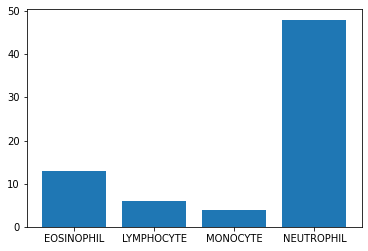

In [ ]:
# Checking the Distribution of the test classes
print('Distribution of the train set classes')
tm1 = glob(test_path + '/EOSINOPHIL' +  '/*.jp*g')
tm2 = glob(test_path + '/LYMPHOCYTE' +  '/*.jp*g')
tm3 = glob(test_path + '/MONOCYTE' +  '/*.jp*g')
tm4 = glob(test_path + '/NEUTROPHIL' +  '/*.jp*g')

dict_train = {'EOSINOPHIL': len(tm1), 'LYMPHOCYTE': len(tm2), 'MONOCYTE': len(tm3), 'NEUTROPHIL': len(tm4)}
plt.bar(dict_train.keys(), dict_train.values())
plt.show()

Finding

The training set is ca equaly distributed
The test set contains very different number of samples for each class

Random Train Set Images


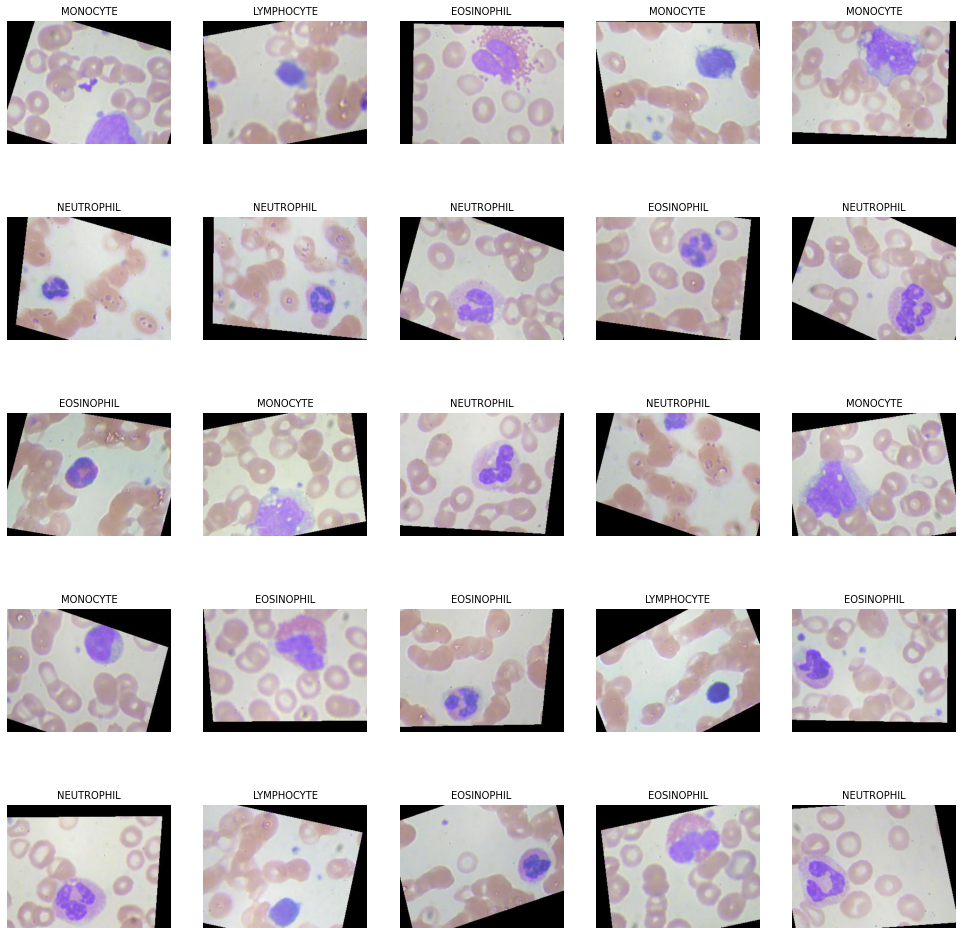

In [ ]:
# Show some images from the Training set
set_to_show = train_path 
#valid_path #test_path #train_path

W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()

n_training = len(image_files)
print('Random Train Set Images')
for i in np.arange(0, W_grid*L_grid):
    
    folder_name = np.random.choice(glob(set_to_show + '/*'))
    pic = random_image = np.random.choice(glob(folder_name + '/*.jp*g'))
    axes[i].imshow(image.load_img(pic))
    axes[i].set_title(folder_name.rsplit('/')[1], fontsize=10)
    axes[i].set_frame_on(True)
    axes[i].axis('off')
    
plt.subplots_adjust(hspace=0.4)

Random Test Set Images


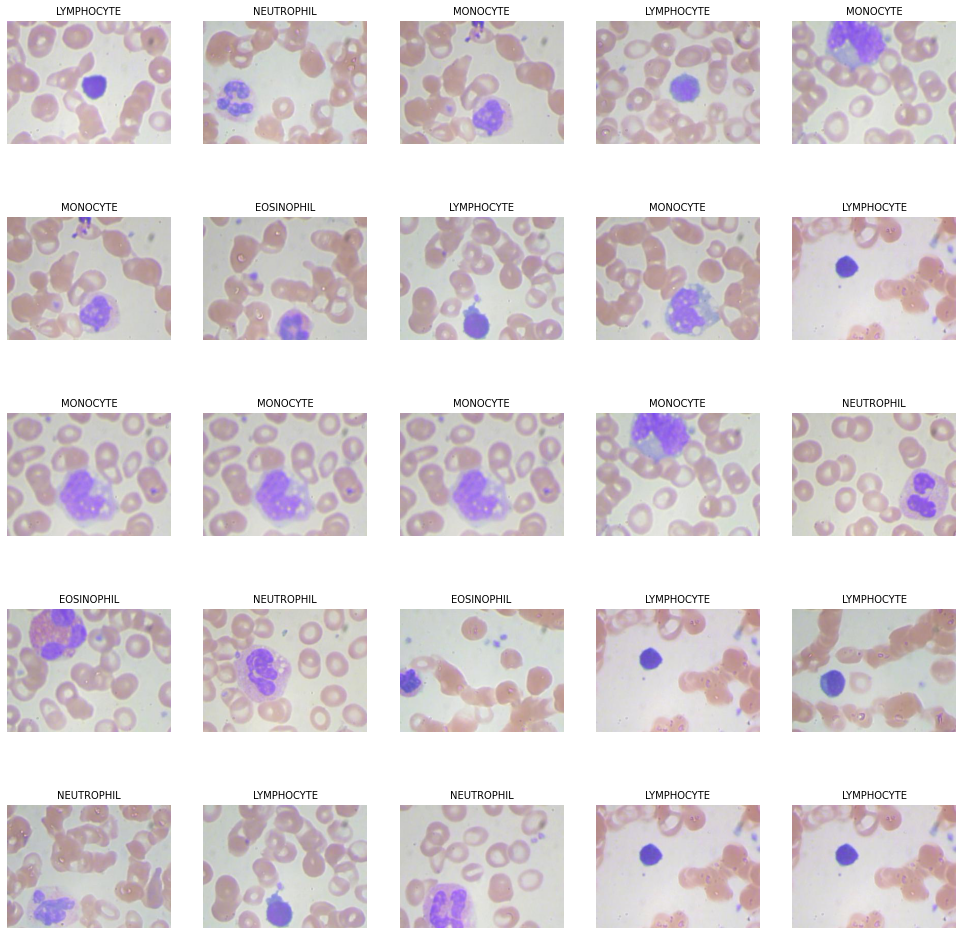

In [ ]:
# Show some images from the Test set
set_to_show = test_path 
#valid_path #test_path #train_path

W_grid = 5
L_grid = 5

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel()

n_training = len(image_files)

print('Random Test Set Images')
for i in np.arange(0, W_grid*L_grid):
    
    folder_name = np.random.choice(glob(set_to_show + '/*'))
    pic = random_image = np.random.choice(glob(folder_name + '/*.jp*g'))
    axes[i].imshow(image.load_img(pic))
    axes[i].set_title(folder_name.rsplit('/')[1], fontsize=10)
    axes[i].set_frame_on(True)
    axes[i].axis('off')
    
plt.subplots_adjust(hspace=0.4)

The training set images comes already after data augumentation

# Model 1 - Basic Inception and Resnet blocks 

In [ ]:
# Set an image size
IMAGE_SIZE = [224, 224]

In [ ]:
# INCEPTION BLOCK
def inception_block(X):
  # 3x3 Filter no pooling
  X_3x3 = Conv2D(8, kernel_size=(1,1))(X)
  X_3x3 = BatchNormalization()(X_3x3)
  X_3x3 = Activation('relu')(X_3x3)
  X_3x3 = ZeroPadding2D(padding=(1, 1))(X_3x3)
  X_3x3 = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), padding='valid')(X_3x3)
  X_3x3 = BatchNormalization()(X_3x3)
  X_3x3 = Activation('relu')(X_3x3)

  # 5x5 Filter no pooling
  X_5x5 = Conv2D(16, kernel_size=(1,1))(X)
  X_5x5 = BatchNormalization()(X_5x5)
  X_5x5 = Activation('relu')(X_5x5)
  X_5x5 = ZeroPadding2D(padding=(2, 2))(X_5x5)
  X_5x5 = Conv2D(32, kernel_size=(5, 5), strides=(1, 1), padding='valid')(X_5x5)
  X_5x5 = BatchNormalization()(X_5x5)
  X_5x5 = Activation('relu')(X_5x5)

  # 1x1 Filter no pooling
  X_1x1 = Conv2D(32, kernel_size=(1,1))(X)
  X_1x1 = BatchNormalization()(X_1x1)
  X_1x1 = Activation('relu')(X_1x1)

  # Additional 1x1 with pooling
  X_pool = MaxPooling2D(pool_size=3, strides=1) (X)
  X_pool = Conv2D(32, kernel_size=(1, 1))(X_pool)
  X_pool = BatchNormalization()(X_pool)
  X_pool = Activation('relu')(X_pool)
  X_pool = ZeroPadding2D(padding=(1)) (X_pool)

  X = inception = concatenate([X_3x3, X_5x5, X_1x1, X_pool], axis=3)
  X = MaxPooling2D(pool_size=2)(X)

  return X

In [ ]:
# Resnet Block
def resnet_block(X):  
  X_shortcut = X

  #Main Path
  X = Conv2D(16, kernel_size=(1, 1), strides=(1, 1))(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(32, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
  X = BatchNormalization()(X)
  X = Activation('relu')(X)

  X = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same')(X)
  X = BatchNormalization()(X)

  #Shortcut Path
  X_shortcut = Conv2D(64, kernel_size=(1,1))(X_shortcut)
  X_shortcut = BatchNormalization()(X_shortcut)

  #Add the path together
  X = Add()([X, X_shortcut])
  X = Activation('relu')(X)

  return X

In [ ]:
# Main Part
i = Input(shape=IMAGE_SIZE + [3])
X = Conv2D(16, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same') (i)
X = Dropout(0.2)(X)
X = MaxPooling2D()(X)
X = BatchNormalization() (X)
X = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same') (X)
X = Conv2D(64, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same') (X)
# X = Dropout(0.1)(X)
X = MaxPooling2D()(X)
X = Conv2D(128, kernel_size=(3, 3), strides=(1, 1), activation='relu', padding='same') (X)
# X = Dropout(0.1)(X)

X = inception_block(X)
X = resnet_block(X)

X = Flatten() (X)
x = Dense(300, activation ='relu')(X)
X = Dropout(0.1)(X)
X = Dense(100, activation ='relu')(X)
# X = Dropout(0.1)(X)
X = Dense(4, activation='softmax') (X)

model = Model(i, X)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 224, 224, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 224, 224, 16) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 112, 112, 16) 0           dropout[0][0]                    
______________________________________________________________________________________________

In [ ]:
opt = tf.keras.optimizers.Adam()
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Create an instance of ImageDataGenerator
gen = ImageDataGenerator(
  rescale=1./255,
)

batch_size=32

In [ ]:
train_generator = gen.flow_from_directory(train_path, target_size=IMAGE_SIZE, 
                                          class_mode='categorical',
                                          batch_size=batch_size,
                                          shuffle=True)

valid_generator = gen.flow_from_directory(valid_path, target_size=IMAGE_SIZE,
                                          class_mode = 'categorical',
                                          batch_size=batch_size)

test_genetrator = gen.flow_from_directory(test_path, target_size=IMAGE_SIZE,
                                          class_mode='categorical',
                                          batch_size=1)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [ ]:
# Early Stopping with patience
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
# Save the best model

#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Lets try with training accuracy
mc = ModelCheckpoint('best_res_incept.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks = [es, mc]

In [ ]:
import time 
start_time = time.time()
r = model.fit_generator(
    train_generator,
    validation_data = valid_generator,
    epochs = 30,
    steps_per_epoch= len(image_files) // batch_size,
    validation_steps = len(valid_image_files) // batch_size,
    callbacks=callbacks
)

end_time = time.time()

# Save the model
model.save('res_incept.h5')
# Save the history file
history = pd.DataFrame(r.history)
history.to_csv(history.to_csv('history_res_incept.csv', index=False))
history.to_csv(history.to_csv('/content/drive/My Drive/Colab Notebooks/Blood_Cells/history_res_incept2.csv', index=False))

# Print elapsed time
time_elapsed = end_time - start_time
print(time_elapsed)

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
311/311 [==============================] - ETA: 0s - loss: 1.7063 - accuracy: 0.2488
Epoch 00001: val_accuracy improved from -inf to 0.25041, saving model to best_res_incept.h5
311/311 [==============================] - 34s 110ms/step - loss: 1.7063 - accuracy: 0.2488 - val_loss: 1.3863 - val_accuracy: 0.2504
Epoch 2/30
311/311 [==============================] - ETA: 0s - loss: 1.3864 - accuracy: 0.2454
Epoch 00002: val_accuracy did not improve from 0.25041
311/311 [==============================] - 33s 106ms/step - loss: 1.3864 - accuracy: 0.2454 - val_loss: 1.3863 - val_accuracy: 0.2496
Epoch 3/30
311/311 [==============================] - ETA: 0s - loss: 1.3864 - accuracy: 0.2472
Epoch 00003: val_accuracy improved from 0.25041 to 0.25122, saving model to best_res_incept.h5
311/311 [==============================] - 33s 107ms/step - loss: 1.3864 - accuracy: 0.2472 - val_loss: 1.3863 - val_accuracy:

KeyboardInterrupt: ignored

In [ ]:
# Load the best model 'best_suggested.h5'
best_model_res_incept = load_model('best_res_incept.h5')
# save to drive
best_model_res_incept.save('/content/drive/My Drive/Colab Notebooks/Blood_Cells/best_model_res_incept.h5')


In [ ]:
# Load the result of the best performing one
best_model_res_incept = load_model('/content/drive/My Drive/Colab Notebooks/Blood_Cells/best_model_res_incept.h5')
history = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Blood_Cells/history_res_incept.csv')

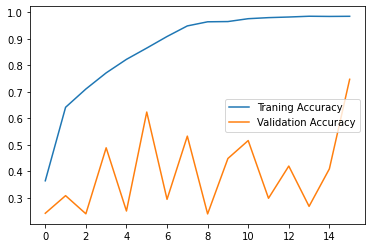

In [ ]:
# Results
plt.plot(history['accuracy'], label='Traning Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
history.tail()

,loss,accuracy,val_loss,val_accuracy
11,0.060889,0.979547,50.397678,0.298574
12,0.055746,0.981864,7.776843,0.419959
13,0.042781,0.984786,38.836323,0.268024
14,0.055539,0.984081,9.219948,0.409369
15,0.056630,0.984584,1.597184,0.747047


The training accuracy reaches 98%, however the validation accuaracy only 74%. Furthermore, the results fluctuates a lot for the validation data.

The next step here is obviously to try to reduce the variance. Since the training data has been already augumented, most probably additional regularisation and different Network architecture would improve the performance.


# ResNet50 with partial pretrained weights

In [ ]:
# Set an image size
IMAGE_SIZE = [224, 224]

In [ ]:
resnet = Resnet50(
    input_shape=IMAGE_SIZE + [3],
    weights='imagenet',
    include_top=False
)

resnet.summary()

In [ ]:
# Print the number of each layer - this is needed to know from which layer to train the weights
i = 0
for layer in resnet.layers:
    print(layer.name)
    print('Layer number' + str(i))
    print()
    i = i +1

In [ ]:
# Train part of the model with our own data

# unfreeze pretrained model weights
resnet.trainable = True

# Tuning certain layers
fine_tune_at = 81
for layers in resnet.layers[:fine_tune_at]:
  layers.trainable = False
  print(layers.name)

In [ ]:
# Another way of choosing the layer to start the training from:
# Define first from where the training to start
first_trainable_layer_name = 'conv4_block1_1_conv'

# Freeze all previous layers
for layer in resnet.layers:
  if layer.name == first_trainable_layer_name:
    break

  layer.trainable = False

# Check for if successful       
print('First trainable layer is :', layer.name)



In [ ]:
# Add the fully connected ANN
K = len(folders)
x = Flatten()(resnet.output)
x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(500, activation='relu')(x)
x = Dropout(0.2)(x)
x = BatchNormalization()(x)
x = Dense(K, activation='softmax')(x)

model_RN = Model(inputs = resnet.input, outputs=x)

model_RN.summary()

In [ ]:
model_RN.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

init_weights = model_RN.get_weights()

In [ ]:
gen_Train = ImageDataGenerator(
  rotation_range=20,
  width_shift_range=0.1,
  height_shift_range=0.1,
  shear_range=0.1,
  zoom_range=0.2,
  horizontal_flip=True,
  vertical_flip=True,
  preprocessing_function=preprocess_input
)

gen_Valid = ImageDataGenerator(
  preprocessing_function=preprocess_input
)

batch_size = 32

In [ ]:
# create generators
train_generator = gen_Train.flow_from_directory(
  train_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)
valid_generator = gen_Valid.flow_from_directory(
  valid_path,
  target_size=IMAGE_SIZE,
  shuffle=True,
  batch_size=batch_size,
)

test_generator = gen_Valid.flow_from_directory(
    test_path,
    target_size=IMAGE_SIZE,
    class_mode=None,
    batch_size=1,
)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
Found 71 images belonging to 4 classes.


In [ ]:
# Load the TensorBoard notebook extension.
%load_ext tensorboard

from datetime import datetime
# Define the Keras TensorBoard callback.
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
# Save the best model

#mc = ModelCheckpoint('best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
# Lets try with training accuracy
mc = ModelCheckpoint('best_resnet.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
callbacks = [es, mc]

In [ ]:
import time 
start_time = time.time()
r = model_RN.fit_generator(
    train_generator,
    validation_data = valid_generator,
    epochs = 15,
    steps_per_epoch= len(image_files) // batch_size,
    validation_steps = len(valid_image_files) // batch_size,
    callbacks=[callbacks, tensorboard_callback]
)

end_time = time.time()

# Save the model
model_RN.save('Blood_Resnet.h5')
# Save the history file
history = pd.DataFrame(r.history)
history.to_csv(history.to_csv('history_Blood_Resnet.csv', index=False))

# Print elapsed time
time_elapsed = end_time - start_time
print(time_elapsed)

Epoch 1/15
311/311 [==============================] - ETA: 0s - loss: 0.1948 - accuracy: 0.9298
Epoch 00001: val_accuracy improved from 0.55235 to 0.63028, saving model to best_resnet.h5
311/311 [==============================] - 128s 412ms/step - loss: 0.1948 - accuracy: 0.9298 - val_loss: 2.4454 - val_accuracy: 0.6303
Epoch 2/15
311/311 [==============================] - ETA: 0s - loss: 0.1433 - accuracy: 0.9530
Epoch 00002: val_accuracy improved from 0.63028 to 0.74675, saving model to best_resnet.h5
311/311 [==============================] - 128s 411ms/step - loss: 0.1433 - accuracy: 0.9530 - val_loss: 0.9679 - val_accuracy: 0.7468
Epoch 3/15
311/311 [==============================] - ETA: 0s - loss: 0.0930 - accuracy: 0.9689
Epoch 00003: val_accuracy did not improve from 0.74675
311/311 [==============================] - 125s 401ms/step - loss: 0.0930 - accuracy: 0.9689 - val_loss: 1.1357 - val_accuracy: 0.7054
Epoch 4/15
311/311 [==============================] - ETA: 0s - loss: 

In [ ]:
# Load the best model 'best_suggested.h5'
best_model_ResNet = load_model('best_resnet.h5')
# save to drive
best_model_ResNet.save('/content/drive/My Drive/Colab Notebooks/Blood_Cells/best_resnet.h5')
history.to_csv(history.to_csv('/content/drive/My Drive/Colab Notebooks/Blood_Cells/history_Resnet.csv', index=False))


',loss,accuracy,val_loss,val_accuracy\n0,0.19479715824127197,0.9297732710838318,2.4454092979431152,0.6302759647369385\n1,0.14333952963352203,0.9530478715896606,0.9678857922554016,0.7467532753944397\n2,0.09303542226552963,0.9688665270805359,1.1356526613235474,0.7053571343421936\n3,0.18328899145126343,0.9381360411643982,1.714031457901001,0.6741071343421936\n4,0.10105129331350327,0.9677581787109375,1.085493803024292,0.6907467246055603\n5,0.12760531902313232,0.9593954682350159,1.3788954019546509,0.6497564911842346\n6,0.09265685081481934,0.9685642123222351,0.676101565361023,0.8031655550003052\n7,0.06711822003126144,0.9777330160140991,1.1538419723510742,0.6996753215789795\n8,0.07038982212543488,0.9795466065406799,1.1983228921890259,0.6578733921051025\n9,0.052164919674396515,0.9831737875938416,2.452089548110962,0.6274350881576538\n10,0.06977587193250656,0.9783375263214111,1.5632251501083374,0.6935876607894897\n11,0.05508853495121002,0.9825692772865295,1.4625457525253296,0.6550324559211731\n12

In [ ]:
evaluation = best_model_ResNet.evaluate_generator(generator=valid_generator,
                         steps=int(np.ceil(len(valid_image_files) / batch_size)))
print(evaluation)
print(best_model_ResNet.metrics_names)

Instructions for updating:
Please use Model.evaluate, which supports generators.
[0.6718275547027588, 0.8033775687217712]
['loss', 'accuracy']


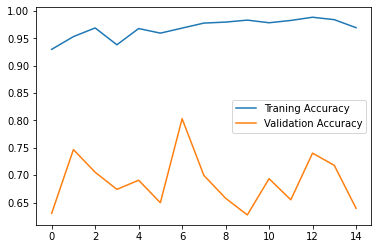

In [ ]:
# Results
plt.plot(history['accuracy'], label='Traning Accuracy')
plt.plot(history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()

In [ ]:
%tensorboard --logdir logs

## Result
Interestingly, even though the Train and Vaildation data seemed so similar for me, the model trained on the Training set did not so well on the Validation set. The Variance is pretty high despite some dropout and data augumentation.

More tunning is needed to handle this. This remains as a further exercise for me.